In [1]:
import numpy as np
import random, time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class m_snake:
    
    def __init__(self):
        
        self.action_space = [0,1,2,3]
        self.Directions = np.array([
            [0, 1], [1, 0 ], [0, -1], [-1,0] 
            ])
        self.screen_size = 10
        self.time_limit   = 5
        self.observation_space = (self.screen_size, self.screen_size)
        
        
    def reset(self):
        init_p = self.screen_size//2 # 5
        self.snake = np.array([[init_p, init_p], [init_p-1,init_p], [init_p-2,init_p]])
        self.head = self.snake[0]
        self.score = 0
        self.health = int(self.screen_size * self.time_limit)
        self.place_fruit()
        self.get_state()
        self.done = False
        return self.state
        
    def get_state(self):
        self.state = np.zeros([self.screen_size+2, self.screen_size+2])
        for s in self.snake: #snake
            self.state[s[0]+1,s[1]+1] = 1 # 몸통
        self.state[self.fruit[0]+1,self.fruit[1]+1] = 2.  #fruit
        self.state[self.head[0]+1, self.head[1]+1] = 3. #snake head
        self.state[0,:]=-1. #wall
        self.state[-1, :]= -1. #wall
        self.state[:,0]= -1. #wall
        self.state[:,-1]= -1. #wall
        pass
        
    def place_fruit(self):
        
        while True:
            x = random.randint(0, self.screen_size-1)
            y = random.randint(0, self.screen_size-1)
            if [x,y] not in [ list(s) for s in self.snake]:
                break
        self.fruit = np.array([x,y])
        pass
    
    def step(self, a):
        
        reward = 0
        move = self.Directions[a] 
        new_head = self.head + np.array(move)
        self.mytest = np.sum(np.abs(self.snake[:-1]-new_head),axis=1) 
        
        # crash on the wall
        if ( new_head[0] not in list(range(self.screen_size)) or
            new_head[1] not in list(range(self.screen_size)) ):
                      
            self.done = True
            reward = -1
        
        # crash on itself
        if 0 in np.sum(np.abs(self.snake[:-1]-new_head),axis=1):
            self.done = True
            reward = -1
        
        # eat a fruit
        if all(new_head == self.fruit):
            self.score +=1
            reward = 1 
            self.health = int(self.time_limit * self.screen_size)+1
            # grow condition
            if self.snake.shape[0] < 12:
                self.snake = np.concatenate([[new_head], self.snake], axis=0)
            else:
                self.snake = np.concatenate([[new_head], self.snake[:-1]], axis=0)
            self.place_fruit()
        else:
            self.snake = np.concatenate([[new_head], self.snake[:-1]], axis=0) 
        
            
        
        self.head = self.snake[0]
        self.get_state()
        self.health -= 1
        
        # time limit check
        if self.health < 0:
            self.done = True
            reward = -1
        
        ## achieve the goal
        if self.score >=100:
            self.done = True
            
        return self.state, reward, self.done, [self.score, self.health]
    
    def render(self):
        clear_output(True)
        plt.figure(figsize=(4,4))
        plt.imshow(self.state)
        plt.title('Score:%3s     Health: %3s' %(self.score, self.health))
        plt.axis('off')
        plt.show()
        time.sleep(.5)

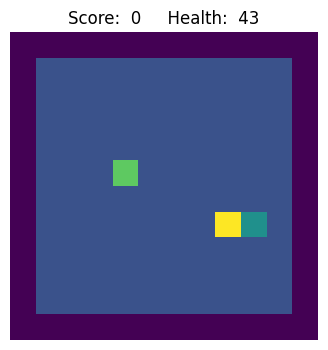

In [3]:
env = m_snake()
env.reset()
d = False
total_r = 0
while not d:
    a = random.randint(0,3)
    _, r, d, _ = env.step(a)
    env.render()
    total_r +=r



In [4]:
import numpy as np
import random, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
class Qagent(torch.nn.Module):
    
    def __init__(self, env):
        super(Qagent, self).__init__()
        
        self.env = env
        self.input_dim = 5
        self.output_dim = 4
        self.fc1 = nn.Linear(self.input_dim, 120)
        self.dropout1 = nn.Dropout(0.15)
        self.fc2 = nn.Linear(120, 240)
        self.dropout2 = nn.Dropout(0.15)
        self.fc3 = nn.Linear(240, self.output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
        
    def get_agent_state(self):
        dist = np.sum((self.env.head-self.env.fruit)**2)
        agent_state = np.concatenate([self.env.head,self.env.fruit, [dist]], axis=0)
        agent_state = agent_state/self.env.screen_size
        return agent_state
    
    def action(self, state, epsilon=0):
        agent_state = self.get_agent_state()
        qvalues = self.forward(torch.from_numpy(agent_state).float())
        coin = random.random()
        # epsilon-greedy action 선택
        if coin < epsilon:
            a = random.randint(0,self.output_dim-1)
        else : 
            a = qvalues.argmax().item() 
    
        return a 
    
    def test(self, test_num, render_op=False):
        
        reward_history =[]
        
        for i in range(test_num):
            s = self.env.reset()
            d = False
            epi_r = 0
            
            while not d:
                
                if render_op:
                    self.env.render()
                a = self.action(s, epsilon=0) #greedy action     
                s, r, d, info = self.env.step(a)
                epi_r += r
            
            reward_history.append(epi_r)
            if render_op:
                print("{}-번째 테스크 결과는 {}".format(i+1, epi_r))
                time.sleep(3)
            
        if render_op:
            print("{}-번 게임의 평균 점수는 {}, 최고점수는 {}".format(test_num, np.mean(reward_history),np.max(reward_history)))
        else:
            return np.mean(reward_history)
        
        
    def save_models(self, name=None):
        if name == None:
            name = 'noname'
        torch.save(self.state_dict(), name + '_qnet.pt')
        print('Models saved successfully')
    
    def load_models(self, name=None):
        if name ==None:
            name = 'noname'
        self.load_state_dict(torch.load(name + '_qnet.pt'))
        print ('Models loaded succesfully')

In [6]:
class ReplayBuffer:
    
    def __init__(self, buffer_limit, mini_size):
        
        self.buffer = deque(maxlen=buffer_limit)
        self.batch_size = mini_size
    
    
    def put(self, sarsd):
        self.buffer.append(sarsd)
    
    def sample(self):
        mini_batch = random.sample(self.buffer, self.batch_size)
        s_list, a_list, r_list, s_prime_list, done_list = [], [], [], [], []
        
        for sarsd in mini_batch:
            s, a, r, s_prime, done = sarsd
            s_list.append(s)
            a_list.append([a])
            r_list.append([r])
            s_prime_list.append(s_prime)
            done_list.append([done])

        return torch.FloatTensor(np.array(s_list)), torch.tensor(np.array(a_list), dtype=int),\
                torch.FloatTensor(np.array(r_list)), torch.FloatTensor(np.array(s_prime_list)),\
                torch.FloatTensor(np.array(done_list))
    
    def size(self):
        return len(self.buffer)

In [7]:
class DQN:

    def __init__(self, agent, hps):
        
        self.agent = agent
        self.env   = self.agent.env
        self.targetA = Qagent(self.env)
        self.targetupdate()
        test_env = m_snake()
        self.testA = Qagent(test_env)
        self.targetupdate()
        self.hps     = hps
        
        self.lrate = self.hps.lr
        self.gamma = self.hps.gamma
        self.ram =  ReplayBuffer(self.hps.buffersize, self.hps.minibatchsize)
        self.target_update_interval = self.hps.target_update_interval
        
        self.update_ctr = 0
        self.training_ctr = 0
        
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.lrate)
        
    
    def targetupdate(self):
        return self.targetA.load_state_dict(self.agent.state_dict())
    
    def plot(self, frame_idx, rewards, test_score, losses):
        clear_output(True)
        plt.figure(figsize=(12,6))
        plt.subplot(131)
        plt.title('Frame %s k. last 10 epi reward mean: %.2f' % (int(frame_idx/1000), np.mean(rewards[-10:])))
        plt.plot(rewards, 'k-')
        plt.subplot(132)
        plt.title('Test Score')
        plt.plot(test_score, 'r--')
        plt.subplot(133)
        plt.title('Loss')
        plt.plot(losses)
        plt.savefig(str(self.hps.save_file_name)+'.png')
        plt.show()
    
    
    def train(self):
            
        s,a,r,s_prime,done = self.ram.sample()
        qvalues = self.agent(s)
        q_a = qvalues.gather(1,a)
        with torch.no_grad():
            max_q_sprime = self.targetA(s_prime).max(1)[0].unsqueeze(1)
        target = r + self.gamma * max_q_sprime * done
        loss = F.mse_loss(q_a, target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
            
    def learning(self):
        self.reward_history =[]
        self.test_history = []
        self.loss_history =[]
        
        ep = lambda frame_num : self.hps.min_ep + (self.hps.init_ep - self.hps.min_ep) * math.exp(-1. * frame_num / self.hps.decay) 
        
        s = self.env.reset()
        d = False
        epi_r = 0
            
        
        while self.training_ctr < self.hps.num_training:
            epsilon = ep(self.training_ctr)
            agent_s = self.agent.get_agent_state()
            a = self.agent.action(s, epsilon) 
            s_prime, r, d, info = self.env.step(a)
            epi_r += r
            done = 0.0 if d else 1.0
            agent_sp = self.agent.get_agent_state()
            if r<1:
                if 0 in env.mytest: r += -1  
                else :
                    dist_change = agent_s[-1]-agent_sp[-1]
                    r += dist_change/3  
                
            
            self.ram.put((agent_s,a,r/50.0, agent_sp, done))
            if d:
                s = self.env.reset()
                d = False
                self.reward_history.append(epi_r)
                epi_r = 0
            else:
                s = s_prime
            
            
            if self.ram.size()> self.hps.start_from:
                self.update_ctr +=1
                loss = self.train()
                self.loss_history.append(loss)
                
            if (self.update_ctr +1) % self.target_update_interval ==0:
                self.targetupdate()
            
            if (self.training_ctr+1)%self.hps.print_interval==0:
                self.testA.load_state_dict(self.agent.state_dict())
                self.test_history.append(self.testA.test(20))
                if np.max(self.test_history) == self.test_history[-1]:
                    self.agent.save_models(self.hps.save_file_name)
                self.plot(self.training_ctr+1, self.reward_history, self.test_history, self.loss_history)
                time.sleep(5)
            self.training_ctr +=1
    

In [8]:
# hyper parameters
class hp:   #collection of hyper parameters
    def __init__(self):
        
        self.save_file_name = 'm_snake_ex' 
        
        self.lr = 1e-4
        self.gamma = 0.99
        self.num_training = int(50e4)
        self.buffersize = int(2e4) 
        self.minibatchsize = 32 
        self.start_from = int(1e3)
        self.print_interval = int(5e3)
        self.target_update_interval = int(5e3)
        self.init_ep = 1
        self.min_ep = 0.01
        self.decay = int(1e4)

In [9]:
env = m_snake()
agent = Qagent(env)
hps = hp()
trainer = DQN(agent, hps)

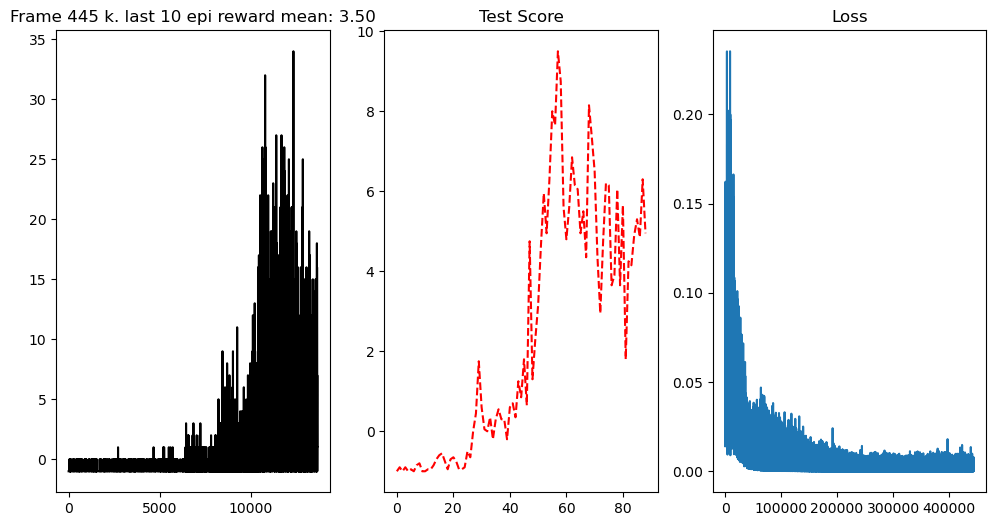

In [ ]:
trainer.learning()

훈련시킨 Agent가 50번 게임했을 때 평균점수를 출력

In [15]:
agent.load_models('m_snake_ex')
#agent.test(1,True)
agent.test(50)




Models loaded succesfully


8.9

<h3> 3번 (배점 10점) 강화학습의 아이디어를 이용하여 해결할 수 있는 문제 (게임 및 자율주행은 제외)를 하나 제시하고, 어떤 방법으로 해결할 수 있다고 생각하는지 본인의 아이디어를 설명하시오. 